### **VALIDACION CRUZADA 5-FOLD**
* Sin conjunto de validación
* Clasificación de 5 categorias 
* Prueba con: RGB, R, G, B, RG, RB, GB, HSV, CMYK, CIElab, Gray scale
* Nuevos: YUV, estiramiento de histograma, ecualización  


In [20]:
import torch
import cv2
import numpy as np
from random import shuffle
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchsummary import summary 
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, average_precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

In [21]:
#Probar que la gpu esta funcionando 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Lectura de direcciones de imágenes en RGB 

In [22]:
#Lectura de direcciones de las imagenes
path_base = '/home/irarijimel/Documentos/CIC/Tesis/Sipakmed/'
folders_cell = ['Dyskeratotic','Koilocytotic','Metaplastic','Parabasal','Superficial-intermediate']
folders_mask = ['imagenes']

full_dir_rgb = []
for indice_cell in range(1,6):#recorre carpetas de celulas
    #print(indice_cell)
    for indice_mask in range(1,2):#recorre carpetas mask
        #print(indice_mask)
        path = path_base + folders_cell[indice_cell-1] + '/' + folders_mask[indice_mask-1] + '/'
        ele_img = os.listdir(path)
        ele_img.sort()#aqui ya tengo los nombres de las iamgenes ej.['001_01_rsze.bmp', '001_02_rsze.bmp', '001_03_rsze.bmp', '001_04_rsze.bmp'...]
        #print(len(ele_img))
        #print(ele_img)

        for i in range(len(ele_img)):#recorre todos los nombres y los guarda
            full_dir_rgb.append(path + ele_img[i])

print(len(full_dir_rgb))
print(full_dir_rgb)


4023
['/home/irarijimel/Documentos/CIC/Tesis/Sipakmed/Dyskeratotic/imagenes/001_01_rsze.bmp', '/home/irarijimel/Documentos/CIC/Tesis/Sipakmed/Dyskeratotic/imagenes/001_02_rsze.bmp', '/home/irarijimel/Documentos/CIC/Tesis/Sipakmed/Dyskeratotic/imagenes/001_03_rsze.bmp', '/home/irarijimel/Documentos/CIC/Tesis/Sipakmed/Dyskeratotic/imagenes/001_04_rsze.bmp', '/home/irarijimel/Documentos/CIC/Tesis/Sipakmed/Dyskeratotic/imagenes/001_05_rsze.bmp', '/home/irarijimel/Documentos/CIC/Tesis/Sipakmed/Dyskeratotic/imagenes/002_01_rsze.bmp', '/home/irarijimel/Documentos/CIC/Tesis/Sipakmed/Dyskeratotic/imagenes/002_02_rsze.bmp', '/home/irarijimel/Documentos/CIC/Tesis/Sipakmed/Dyskeratotic/imagenes/002_03_rsze.bmp', '/home/irarijimel/Documentos/CIC/Tesis/Sipakmed/Dyskeratotic/imagenes/002_04_rsze.bmp', '/home/irarijimel/Documentos/CIC/Tesis/Sipakmed/Dyskeratotic/imagenes/002_05_rsze.bmp', '/home/irarijimel/Documentos/CIC/Tesis/Sipakmed/Dyskeratotic/imagenes/002_06_rsze.bmp', '/home/irarijimel/Document

In [23]:
#Generar etiquetas para cada clase
trg1 = []
trg2 = []
trg3 = []
trg4 = []
trg5 = []
target_total = []
for indice_cell in range(1,6):
  path = path_base + folders_cell[indice_cell-1] +'/imagenes/'#solo guardo las img_rgb
  ele_img = os.listdir(path)
  #print(path)
  print('Indice: ',indice_cell)

  if indice_cell == 1:
    trg1 = np.zeros((1,len(ele_img)),dtype=int)#etiquetas pra dyskeratotic
    print(trg1.shape)
    #print(trg1)
  elif indice_cell == 2:
    trg2 = np.ones((1,len(ele_img)),dtype=int)*1#etiquetas pra koilocytotic
    print(trg2.shape)
    #print(trg2)
  elif indice_cell == 3:
    trg3 = np.ones((1,len(ele_img)),dtype=int)*2#etiquetas pra metaplastic
    print(trg3.shape)
    #print(trg3)
  elif indice_cell == 4:
    trg4 = np.ones((1,len(ele_img)),dtype=int)*3#etiquetas pra parabasal
    print(trg4.shape)
    #print(trg4)
  else:
    trg5 = np.ones((1,len(ele_img)),dtype=int)*4#etiquetas pra superficial-intermediate
    print(trg5.shape)
    #print(trg5)


target_total = np.concatenate((trg1,trg2,trg3,trg4,trg5),axis=1)
target_total = np.transpose(target_total)
print('Total de targets: ',target_total.shape)
print(target_total)

Indice:  1
(1, 813)
Indice:  2
(1, 807)
Indice:  3
(1, 792)
Indice:  4
(1, 787)
Indice:  5
(1, 824)
Total de targets:  (4023, 1)
[[0]
 [0]
 [0]
 ...
 [4]
 [4]
 [4]]


**Visualizar imágenes aleatorias**

/tmp/ipykernel_4173/201867030.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  aux = int(target_total[num_aleat1])
/tmp/ipykernel_4173/201867030.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  aux = int(target_total[num_aleat1])


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

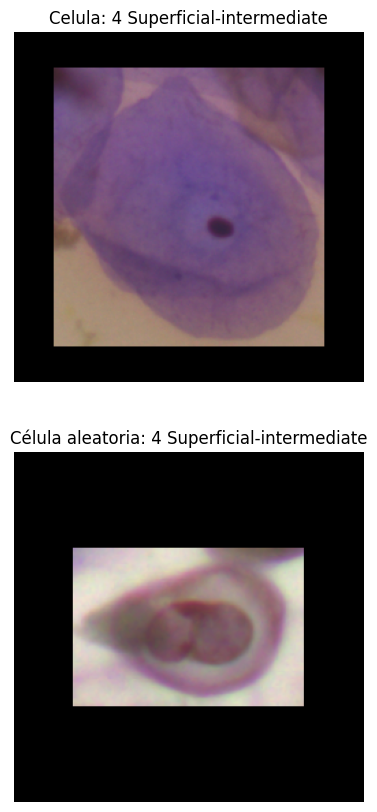

In [24]:
num_aleat1 = np.random.randint(0,high=4023-1)
num_aleat2 = np.random.randint(0,high=4023-1)

img = cv2.imread(full_dir_rgb[num_aleat1])
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].imshow(img)
aux = int(target_total[num_aleat1])
ax[0].set_title(f'Celula: {aux} {folders_cell[aux]}')
ax[0].axis('off')

img = cv2.imread(full_dir_rgb[num_aleat2])
ax[1].imshow(img)
aux = int(target_total[num_aleat1])
ax[1].set_title(f'Célula aleatoria: {aux} {folders_cell[aux]}')
ax[1].axis('off')


**Separ conjuntos de antrenamiento**

In [25]:
#Combinación de direcciónes y separación 75:10:10
shuffle_data = True  # shuffle the addresses before saving
if shuffle_data:
    d = list(zip(full_dir_rgb,target_total))#zip combina las 3 listas
    shuffle(d)#aleatorizar
    full_dir_rgb, target_total = zip(*d)#separa los elementos

#Direcciones de entrenamiento
train_dir_rgb = full_dir_rgb[0:int(len(full_dir_rgb) * 0.80)]
train_target = target_total[0:int(len(target_total) * 0.80)]

#Direcciones de prueba
test_dir_rgb = full_dir_rgb[(int(len(full_dir_rgb) * 0.80)):int(len(full_dir_rgb))]
test_target = target_total[(int(len(target_total) * 0.8)):int(len(target_total))]

#Direcciones de validación
#val_dir_rgb = full_dir_rgb[(int(len(full_dir_rgb) * 0.9)):len(full_dir_rgb)]
#val_target = target_total[(int(len(target_total) * 0.9)):len(target_total)]

print("V. train rgb: ",len(train_dir_rgb))
print("V. test rgb: ",len(test_dir_rgb))
print("V. total: ",len(train_dir_rgb)+len(test_dir_rgb))
print("Target train: ",len(train_target))
print("Target test: ",len(test_target))
print("Target total: ",len(train_target)+len(test_target))

#Convertir los targets a tensores 
train_target = np.array(train_target)
test_target = np.array(test_target)
#val_target = np.array(val_target)

train_tensor = torch.tensor(train_target, dtype=torch.long)
test_tensor = torch.tensor(test_target, dtype=torch.long)
#val_tensor = torch.tensor(val_target, dtype=torch.long)

train_tensor = train_tensor.squeeze()#Dejarlo solo con una dimension los labels
#val_tensor = val_tensor.squeeze()
test_tensor = test_tensor.squeeze()


V. train rgb:  3218
V. test rgb:  805
V. total:  4023
Target train:  3218
Target test:  805
Target total:  4023


In [26]:
print(test_tensor.shape)

torch.Size([805])


**Transformaciones**

In [27]:
#Tranformacion para VALIDACION Y ENTRENAMIENTO
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Volteo horizontal aleatorio
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),  # Rotación aleatoria de hasta 10 grados
    transforms.ToTensor()
])

In [28]:
transform_test = transforms.Compose([
    transforms.ToTensor()
])

In [29]:
#Transformacion al espacio YUV
def yuv_space_model(img):
    img = np.array(img)
    #Normalizamos de [0-1]
    img_nor = np.zeros((img.shape))

    #Obtener valores min y max
    min_r = int(np.min(img[:,:,0]))
    max_r = int(np.max(img[:,:,0]))

    min_g = int(np.min(img[:,:,1]))
    max_g = int(np.max(img[:,:,1]))

    min_b = int(np.min(img[:,:,2]))
    max_b = int(np.max(img[:,:,2]))

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img_nor[i,j,0] = (img[i,j,0] - min_r)/(max_r - min_r)
            img_nor[i,j,1] = (img[i,j,1] - min_g)/(max_g - min_g)
            img_nor[i,j,2] = (img[i,j,2] - min_b)/(max_b - min_b)

    img_nor_aux = Image.fromarray((img_nor*255).astype(np.uint8))

    #Conversion a YUV
    yuv_img = np.zeros(img.shape)

    for i in range(yuv_img.shape[0]):
        for j in range(yuv_img.shape[1]):
            r = img_nor[i,j,0]
            g = img_nor[i,j,1]
            b = img_nor[i,j,2]

            yuv_img[i,j,0] = 0.2990*r + 0.5870*g + 0.1140*b
            yuv_img[i,j,1] = -0.1471*r - 0.2888*g + 0.4359*b
            yuv_img[i,j,2] = 0.6148*r - 0.5148*g - 0.1000*b

    yuv_img_aux = Image.fromarray((yuv_img*255).astype(np.uint8))

    return yuv_img,yuv_img_aux,img_nor_aux


torch.Size([256, 256, 3])
torch.Size([256, 256, 3])


/tmp/ipykernel_4173/290689288.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  aux = int(target_total[num_aleat1])
/tmp/ipykernel_4173/290689288.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  aux = int(target_total[num_aleat1])


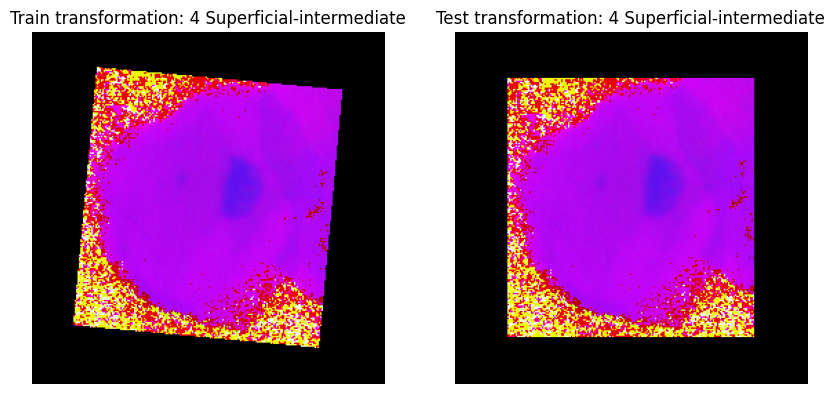

In [19]:
#Comprobaciones de tranformaciones y funciones
num_aleat1 = np.random.randint(0,high=3218-1)
num_aleat2 = np.random.randint(0,high=805-1)

img = Image.open(train_dir_rgb[num_aleat1])

_,img,_ = yuv_space_model(img)

img1 = transform_train(img)
img1 = np.transpose(img1,(1,2,0))

fig, ax = plt.subplots(1,2,figsize=(10,10))
aux = int(target_total[num_aleat1])
ax[0].imshow(img1)
ax[0].set_title(f'Train transformation: {aux} {folders_cell[aux]}')
ax[0].axis('off')

print(img1.shape)

img1 = transform_test(img)
img1 = np.transpose(img1,(1,2,0))
aux = int(target_total[num_aleat1])
ax[1].imshow(img1)
ax[1].set_title(f'Test transformation: {aux} {folders_cell[aux]}')
ax[1].axis('off')

print(img1.shape)


In [ ]:
#probar la clase los transformadores
from PIL import Image, ImageOps
import numpy as np
import skimage 
import cv2
rgb1 = '/home/irarijimel/Documentos/CIC/Tesis/Sipakmed/Dyskeratotic/imagenes/211_02_rsze.bmp'
rgb2 = '/home/irarijimel/Documentos/CIC/Tesis/Sipakmed/Dyskeratotic/imagenes/002_01_rsze.bmp'

#cito = cv2.imread(citoplasma, cv2.IMREAD_UNCHANGED)
#nuc = cv2.imread(nucleo, cv2.IMREAD_UNCHANGED)

rgb1 = Image.open(rgb1)
rgb2 = Image.open(rgb2)

#rgb1 = rgb1.getchannel('B')
#rgb2 = rgb2.getchannel('G')

#img1 = ImageOps.grayscale(rgb1) 
#img1.show()
img1 = rgb1.convert('CMYK')
c,m,y,k = img1.split()
#h.show()
#s.show()
k.show()

img2 = np.array(rgb1)
img_lab = skimage.color.rgb2lab(img2)

l = img_lab[:,:,0]
l_pill = Image.fromarray(l)
#l_pill.show()


img1 = rgb1
print(img1.mode)
print('Tamaño de imagen: ',img1.size)
print('Número de canales: ',len(img1.getbands()))
print(type(img1))

#CODIGO PARA DOS CANALES 
arr = np.array(img1)#convertimos a arreglo
        
r = arr[:,:,0]
g = arr[:,:,1]
b = arr[:,:,2]

new = np.zeros((256,256,2),dtype=np.uint8)
#new[:,:,0] = g
#new[:,:,1] = b

new = np.stack((r,g),axis=-1)

print('Tamaño de imagen: ',new.shape)

new = np.zeros((256,256,3),dtype=np.uint8)
new[:,:,0] = 0
new[:,:,1] = g
new[:,:,2] = b

img1 = Image.fromarray(new)
#img1.show()
#new = np.stack((r,g,b),axis=-1)
print('Tamaño de imagen: ',new.shape)
print(type(new))


#print('Número de canales: ',len(new.getbands()))


#img1 = Image.fromarray(new, mode='LA')   

#h,s,v = img1.split()
#img1.show()
#img1 = transform(img1)
#print(img1)
#img2 = transform(rgb2)

#img1 = np.transpose(new,(1,2,0))
#cv2.imshow('hola',new)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#img2 = np.transpose(img2,(1,2,0))

#img1.show()
#plt.figure(figsize=(5,5))
#plt.imshow(img1,cmap='gray')

#plt.figure(figsize=(5,5))
#plt.imshow(img2,cmap='gray')

#plt.show

RGB
Tamaño de imagen:  (256, 256)
Número de canales:  3
<class 'PIL.BmpImagePlugin.BmpImageFile'>
Tamaño de imagen:  (256, 256, 2)
Tamaño de imagen:  (256, 256, 3)
<class 'numpy.ndarray'>


**Creación de dataloader para manejar los datos: TRAIN Y TEST_VALIDATION**

In [30]:
#Preparar el dataset creando una clase personalizada con dos imagenes de entrada
#Esta clase es mi generador en tensorflow ENTRENAMIENTO
class ImageDaset(Dataset):
    def __init__(self,dir_rgb,train_tensor,transform = None):
        self.dir_rgb = dir_rgb#direcciones de las imagenes
        self.train_tensor = train_tensor#etiquetas de las imagenes
        self.transform = transform#tranformaciones 

    def __len__(self):
        #devuelve la cantidad de los datos del dataset
        return len(self.dir_rgb)
    
    def __getitem__(self, idx):
        #devuelve una imagen y su etiqueta dad una posicion
        #idx indice de la imagen 
        #devuelve una tupla con las dos imagenes y etiquetas
        # Cargar la imagen desde su ruta
        rgb_path = self.dir_rgb[idx]#ruta del citoplasma

        # Obtener la etiqueta correspondiente
        label = self.train_tensor[idx]

        #Procesar la imagen
        img = Image.open(rgb_path)

        #CODIGO PARA PASAR A CMYK, LAB
        #img1 = img#para rgb
        _,img1,_ = yuv_space_model(img)
        #h,s,v = img1.split()
        #img1 = v

        #CODIGO PARA ESCALA DE GRISES
        #img1 = ImageOps.grayscale(img)

        #CODIGO PARA SOLO UN CANAL
        #img1 = img.getchannel('B')

        #CODIGO PARA DOS CANALES 
        #arr = np.array(img)#convertimos a arreglo
        
        #r = arr[:,:,0]
        #g = arr[:,:,1]
        #b = arr[:,:,2]

        #new = np.zeros((256,256,2),dtype=np.uint8)
        #new = np.stack((g,b),axis=-1)
        #img1=new
        #new[:,:,0] = g
        #new[:,:,1] = b

        #img1 = Image.fromarray(new, mode='LA')    
       
        # Aplicar las transformaciones (si existen)
        if self.transform:
            img = self.transform(img1)#para que se haga la misma tranformacion 


        return img,label  # Retornar las imagenes y su etiqueta


In [31]:
#Funcion para resetear los pesos de la red 
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [32]:
#Definir el modelo con dos entradas
class BMaskCNN(nn.Module):
    def __init__(self, num_class):
        super(BMaskCNN, self).__init__()

        self.cov1c = nn.Conv2d(3,32,kernel_size=5,stride=1,padding='valid')
        self.bch1c = nn.BatchNorm2d(32)
        self.rel1c = nn.ReLU()
        self.avg1c = nn.MaxPool2d(kernel_size=3, stride=1)

        self.cov2c = nn.Conv2d(32,64,kernel_size=3,stride=2,padding='valid')
        self.bch2c = nn.BatchNorm2d(64)
        self.rel2c = nn.ReLU()
        self.avg2c = nn.MaxPool2d(kernel_size=3, stride=1)

        #Rama despues juntar las ramas
        self.c3 = nn.Conv2d(64,128,kernel_size=5,stride=2,padding='valid')
        self.bch3 = nn.BatchNorm2d(128)
        self.rel3 = nn.ReLU()
        self.avg3 = nn.MaxPool2d(kernel_size=3,stride=2)

        self.c4 = nn.Conv2d(128,128,kernel_size=3,stride=2,padding='valid')
        self.bch4 = nn.BatchNorm2d(128)
        self.rel4 = nn.ReLU()
        self.avg4 = nn.MaxPool2d(kernel_size=3,stride=1)
        
        #Fully connected 
        self.fc1 = nn.Linear(128*12*12,1000)
        self.rel1 = nn.ReLU()
        self.dr1 = nn.Dropout(0.5)

        #self.fc2 = nn.Linear(2000,510)
        #self.rel2 = nn.ReLU()
        #self.dr2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(1000,128)
        self.rel33 = nn.ReLU()

        self.fcout = nn.Linear(128,num_class)

    def forward(self, x1):
        #imagen rgb
        x1 = self.avg1c(self.rel1c(self.bch1c(self.cov1c(x1))))
        x1 = self.avg2c(self.rel2c(self.bch2c(self.cov2c(x1))))

        #Seguir con las convoluciones
        x3 = self.avg3(self.rel3(self.bch3(self.c3(x1))))
        x4 = self.avg4(self.rel4(self.bch4(self.c4(x3))))

        #flatten
        x = torch.flatten(x4, start_dim=1)
        
        #Capas fully connected
        x5 = self.rel1(self.fc1(x))
        #x6 = self.dr2(self.rel2(self.fc2(x5)))
        x7 =self.rel33(self.fc3(x5))
        outputs = self.fcout(x7)    

        return outputs

        

In [33]:
#Crear una instancia del modelo 
model = BMaskCNN(num_class=5)
model = model.to(device)#montar el modelo a la gpu

In [34]:
input1_size = (3,256,256)
summary(model, input_size=[input1_size])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 252, 252]           2,432
       BatchNorm2d-2         [-1, 32, 252, 252]              64
              ReLU-3         [-1, 32, 252, 252]               0
         MaxPool2d-4         [-1, 32, 250, 250]               0
            Conv2d-5         [-1, 64, 124, 124]          18,496
       BatchNorm2d-6         [-1, 64, 124, 124]             128
              ReLU-7         [-1, 64, 124, 124]               0
         MaxPool2d-8         [-1, 64, 122, 122]               0
            Conv2d-9          [-1, 128, 59, 59]         204,928
      BatchNorm2d-10          [-1, 128, 59, 59]             256
             ReLU-11          [-1, 128, 59, 59]               0
        MaxPool2d-12          [-1, 128, 29, 29]               0
           Conv2d-13          [-1, 128, 14, 14]         147,584
      BatchNorm2d-14          [-1, 128,

In [35]:
#Configuraciones generales para el entrenamiento 
k_folds = 5#numero de pliegues 
num_epochs = 200
batch = 32
criterion = torch.nn.CrossEntropyLoss()  # Cambia si usas otra función de pérdida
results_train = {}#para los resultados de cada fold, diccionario
results_test = {}
torch.manual_seed(42)


In [36]:
#Jusntar las direcciones en un solo dataset
dataset = train_dir_rgb + test_dir_rgb
targets = torch.cat((train_tensor,test_tensor),0)

print('Tamaño de dataset: ', len(dataset))
print('Tamaño de targets: ', targets.shape)

Tamaño de dataset:  4023
Tamaño de targets:  torch.Size([4023])


**Validacion cruzada**

In [ ]:
#5-fold cross validation 
kfold = KFold(n_splits=k_folds, shuffle=False)
loss_total = []
acc_total = []
predictions_total = []
labels_total = []
dataset_total = list(range(len(dataset)))
for fold,(train_ids, test_ids) in enumerate(kfold.split(dataset_total)):
    print(f'Fold {fold}')
    print('------------------------')

    #Crear datasets con transformaciones distintas
    train_dataset = ImageDaset(dataset, targets, transform=transform_train)
    test_dataset = ImageDaset(dataset, targets, transform=transform_test)

    #Crear subconjuntos con los índices
    train_subset = Subset(train_dataset, train_ids)
    test_subset = Subset(test_dataset, test_ids)

    #DataLoaders
    train_dataloader = DataLoader(train_subset, batch_size=batch, shuffle=True)
    test_dataloader = DataLoader(test_subset, batch_size=batch, shuffle=False)

    '''
    #Muestrea elementos aleatoriamente de una lista sin remplazarlos
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)


    #Creamos los dataloader para entrenamiento y prueba
    train_dataloader = DataLoader(dataset_total, batch_size = batch, sampler=train_subsampler)
    test_dataloader = DataLoader(dataset_total,batch_size=batch,sampler=test_subsampler)
    '''
   
    #Ya inicialice mi modelo ahora el optimizador
    model.apply(reset_weights)
    optimizer = torch.optim.Adam(model.parameters())# lr=1e-3)

    loss_train = []
    acc_train = []
    #Ahora vamos a crear el loop para las epocas de cada fold, en mi caso 300
    for epoch in range(num_epochs):
        # Modo entrenamiento
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0
        for batch_idx, (images1, labels) in enumerate(train_dataloader):
            # Mover datos al dispositivo (GPU o CPU)
            images1,labels = images1.to(device), labels.to(device)
            
            # Pasar las imágenes al modelo
            outputs = model(images1)

            # Calcular la pérdida
            loss = criterion(outputs, labels)

            # Retropropagación y optimización
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calcular el número de predicciones correctas
            _, predicted = torch.max(outputs, 1)  # Índices de las clases predichas
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            if batch_idx % 10 == 0:  # Imprimir cada 10 lotes
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

        # Calcular el accuracy para la época
        epoch_loss = running_loss / len(train_dataloader)
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

        loss_train.append(epoch_loss)
        acc_train.append(accuracy)
        results_train[fold] = accuracy#guardamos el ultimo valor de acc de train

    loss_total.append(loss_train)
    acc_total.append(acc_train)

    print(f'Entrenamiento {fold} terminado. Guardando el modelo')
    model_name_fold = f'/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/Modelos_y_Dataloder/cross_{fold}_5class_YUV.pth'
    
    torch.save(model.state_dict(), model_name_fold) 

    #El proceso de un fold se ha terminado, comenzar con TEST
    correct = 0
    total = 0
  
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Deshabilitar el cálculo de gradientes para ahorrar memoria
        for images1, labels in test_dataloader:
            # Mover datos al dispositivo
            images1, labels = images1.to(device), labels.to(device)

            # Realizar predicciones
            outputs = model(images1)

            # Obtener las predicciones
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Guardar las predicciones y etiquetas reales para análisis posterior (opcional)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular métricas
    #average_loss = test_loss / len(test_dataloader)
    accuracy = 100 * correct / total
    

    print(f"Test Accuracy: {accuracy:.2f}%")
    print('----------------------------')
    results_test[fold] = accuracy
    #Calcular matri de confucsion y guardarla
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    predictions_total.append(all_predictions)#estoy gurdando la info y despues puedo hacer las matrices 
    labels_total.append(all_labels)
    #cm = metrics.confusion_matrix(all_labels, all_predictions)
    #cm_total[fold]
    

#Vemos todos los resultados de los folds
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results_test.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results_test.items())} %')

    

        


Fold 0
------------------------
Reset trainable parameters of layer = Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=valid)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=valid)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=valid)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=18432, out_features=100

In [ ]:
#Guardar los dataloader
torch.save(test_dataloader,'/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/Modelos_y_Dataloder/dataloader_test_5class_yuv.pth')
torch.save(train_dataloader,'/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/Modelos_y_Dataloder/dataloader_ train_5class_yuv.pth')


In [22]:
#Acc promedio de TRAIN
f1 = acc_total[0]
f2 = acc_total[1]
f3 = acc_total[2]
f4 = acc_total[3]
f5 = acc_total[4]
prom_acc_train = (f1[-1]+f2[-1]+f3[-1]+f4[-1]+f5[-1])/5
print('Promedio acc de trian: ',prom_acc_train)

Promedio acc de trian:  99.0554219807772


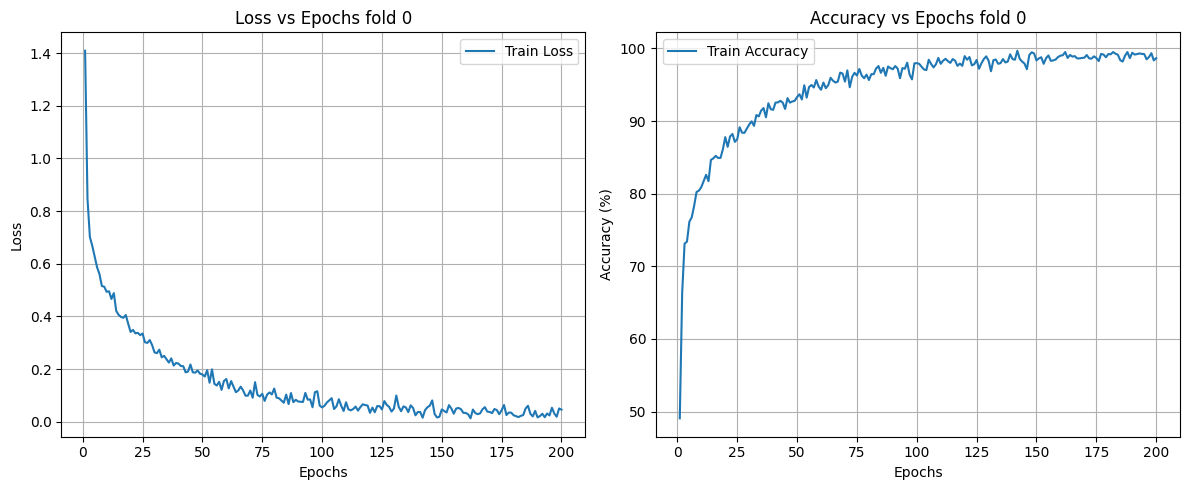

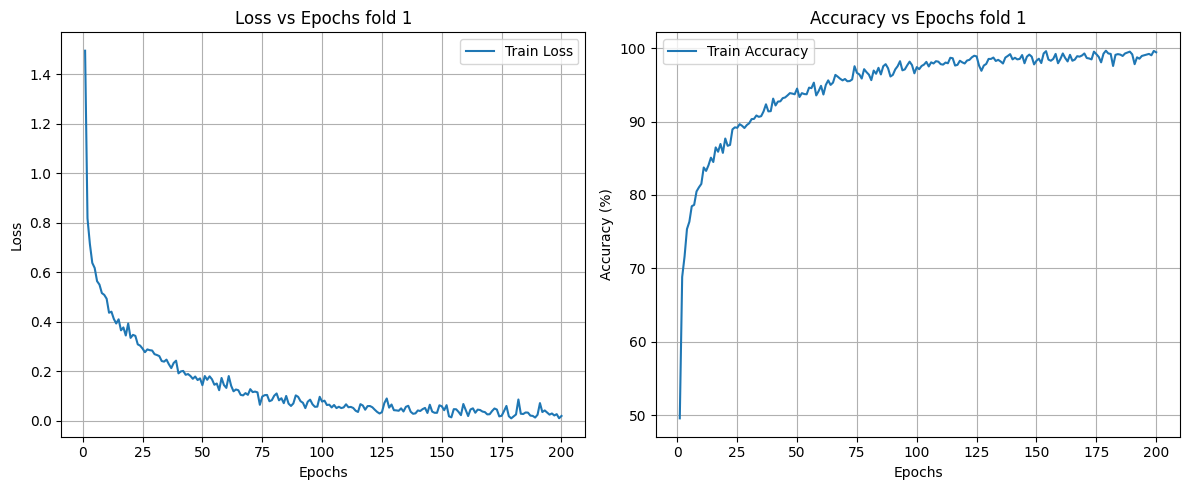

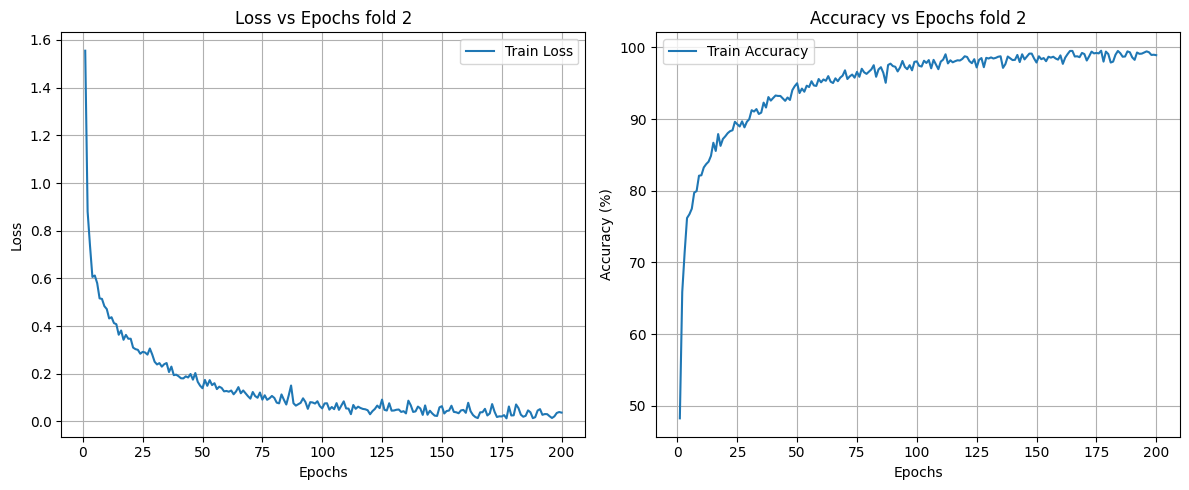

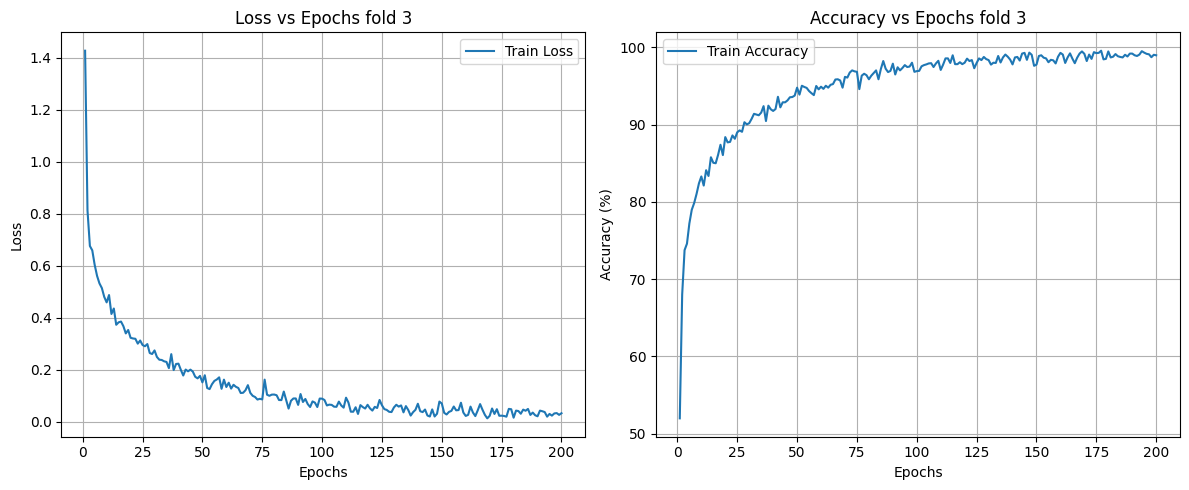

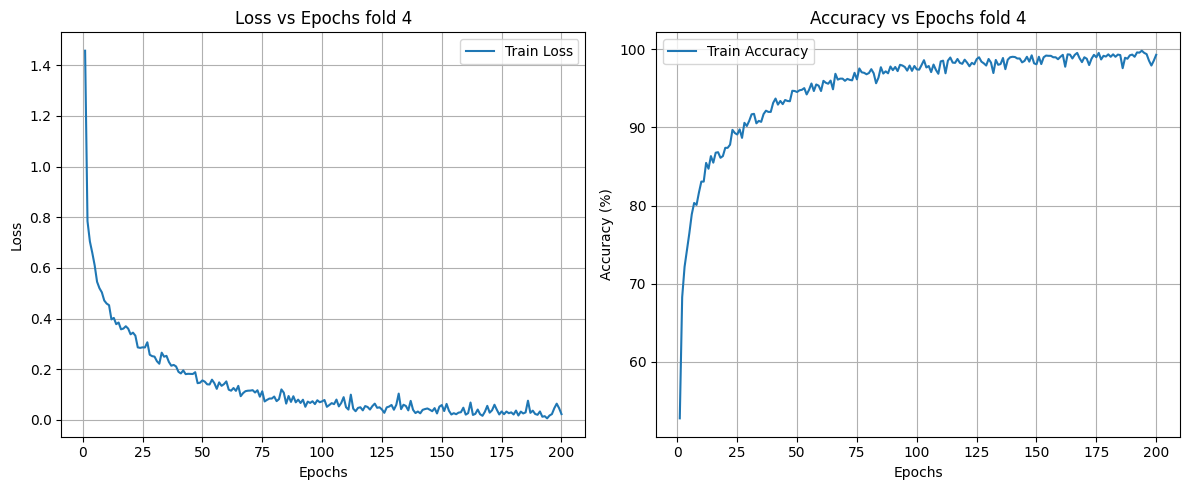

In [ ]:
#Graficar loss y acc de los cinco folds

for fold in range(len(loss_total)):
    plt.figure(figsize=(12, 5))
    
    # Subgráfico para Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), loss_total[fold], label="Train Loss")
    #plt.plot(range(1, num_epochs + 1), loss_val, label="Validation Loss", linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss vs Epochs fold {fold}")
    plt.legend()
    plt.grid(True)

    # Subgráfico para Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), acc_total[fold], label="Train Accuracy")
    #plt.plot(range(1, num_epochs + 1), acc_val, label="Validation Accuracy", linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Accuracy vs Epochs fold {fold}")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_5Classes/Loss/loss_acc_yuv{fold}.jpg", bbox_inches='tight')


    plt.tight_layout()
    plt.show()


### Matrices de confusión de TEST

**Matrices de confusión con decimales**

MATRIZ DE CONFUSION DE CADA FOLD


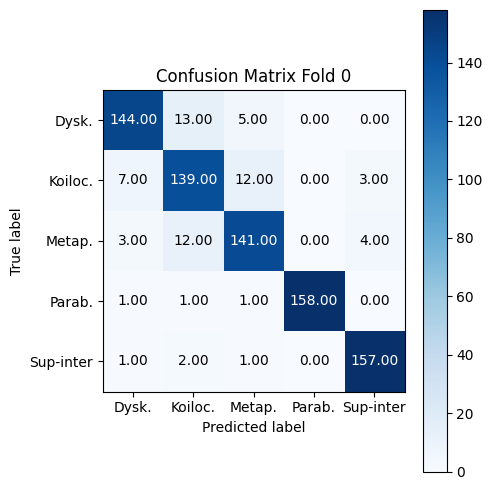

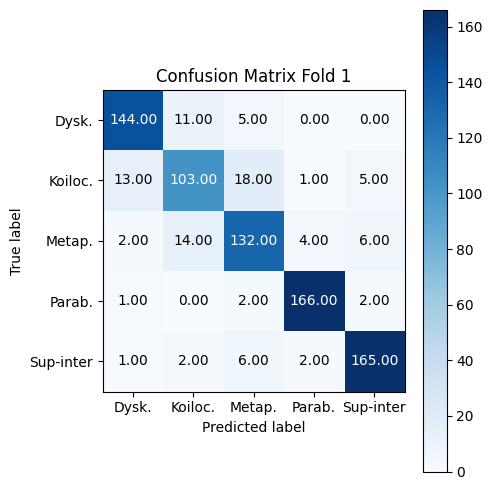

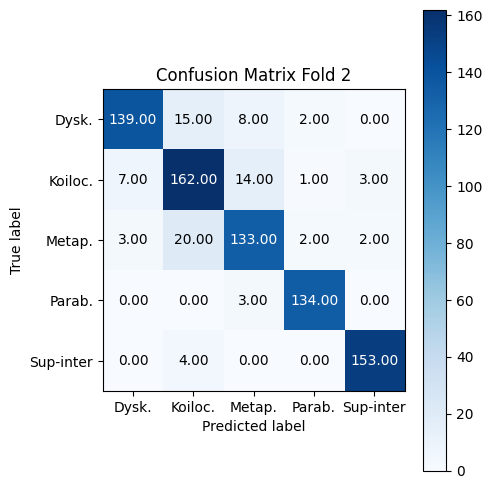

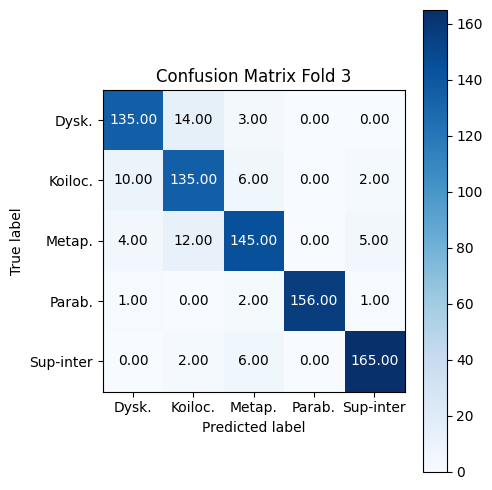

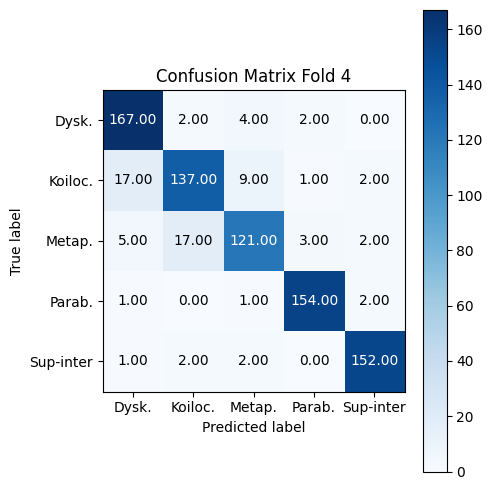

In [ ]:
#vamos a visualizar todas las matrices de confusion para cada fold 
print("MATRIZ DE CONFUSION DE CADA FOLD")
target_names = ['Dysk.','Koiloc.','Metap.','Parab.','Sup-inter']
cm_normalized_total_ORG = np.zeros((5,5))
for fold in range(len(predictions_total)):
    cm = metrics.confusion_matrix(labels_total[fold], predictions_total[fold])
    #print(cm)
    #cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = cm
    cm_normalized_total_ORG = cm_normalized + cm_normalized_total_ORG
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=target_names, yticklabels=target_names,
        title=f'Confusion Matrix Fold {fold}',
        ylabel='True label',
        xlabel='Predicted label')

    fmt = '.2f'
    thresh = cm_normalized.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm_normalized[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > thresh else "black")
            
    plt.savefig(f"/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_5Classes/Matrix/matrix_yuv{fold}.jpg", bbox_inches='tight')
    fig.tight_layout()
    plt.show()


**Matrices de confusión promedio con decimales**

MATRIZ DE CONFUSION PROMEDIO
[[145.8  11.    5.    0.8   0. ]
 [ 10.8 135.2  11.8   0.6   3. ]
 [  3.4  15.  134.4   1.8   3.8]
 [  0.8   0.2   1.8 153.6   1. ]
 [  0.6   2.4   3.    0.4 158.4]]


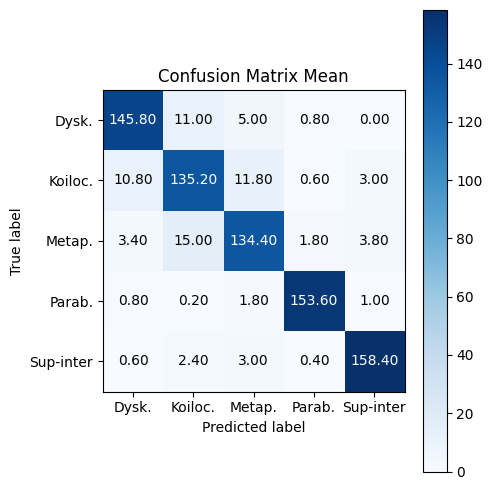

In [ ]:
#Matriz de confusion promedio con decimales
print("MATRIZ DE CONFUSION PROMEDIO")
cm_normalized_total = cm_normalized_total_ORG/5
print((cm_normalized_total))
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm_normalized_total, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=target_names, yticklabels=target_names,
    title='Confusion Matrix Mean',
    ylabel='True label',
    xlabel='Predicted label')

fmt = '.2f'
thresh = cm_normalized_total.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm_normalized_total[i, j], fmt),
                ha="center", va="center",
                color="white" if cm_normalized_total[i, j] > thresh else "black")
        
plt.savefig("/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_5Classes/Matrix/matrix_promedio_decimales_yuv.jpg", bbox_inches='tight')

fig.tight_layout()
plt.show()



**Matrices de confusión promedio redondeado**

MATRIZ DE CONFUSION PROMEDIO
[[146.  11.   5.   1.   0.]
 [ 11. 135.  12.   1.   3.]
 [  3.  15. 134.   2.   4.]
 [  1.   0.   2. 154.   1.]
 [  1.   2.   3.   0. 158.]]


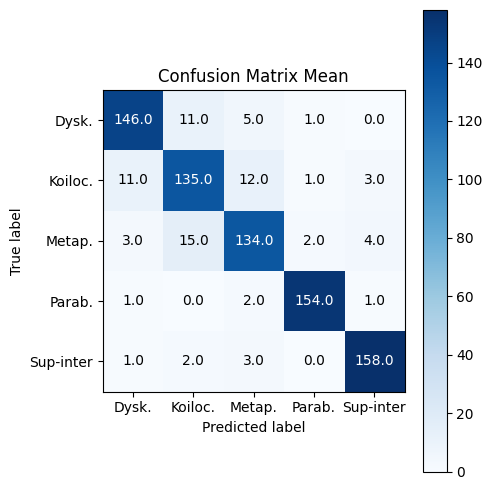

In [ ]:
#Matriz de confusion promedio con decimales
print("MATRIZ DE CONFUSION PROMEDIO")
cm_normalized_total = np.round(cm_normalized_total_ORG/5)
print((cm_normalized_total))
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm_normalized_total, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=target_names, yticklabels=target_names,
    title='Confusion Matrix Mean',
    ylabel='True label',
    xlabel='Predicted label')

fmt = '.2f'
thresh = cm_normalized_total.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm_normalized_total[i, j]),
                ha="center", va="center",
                color="white" if cm_normalized_total[i, j] > thresh else "black")
        
plt.savefig("/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_5Classes/Matrix/matrix_promedio_sin_decimales_yuv.jpg", bbox_inches='tight')

fig.tight_layout()
plt.show()


MATRIZ DE CONFUSION DE CADA FOLD


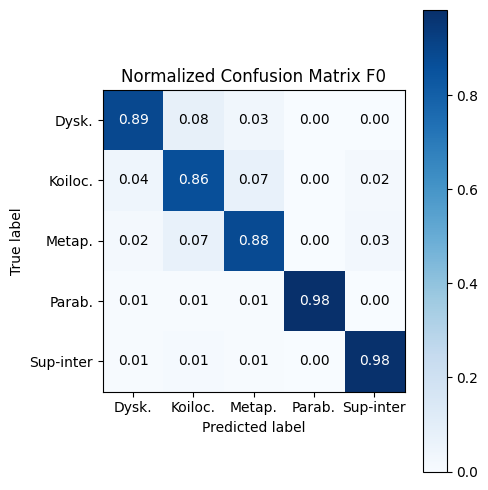

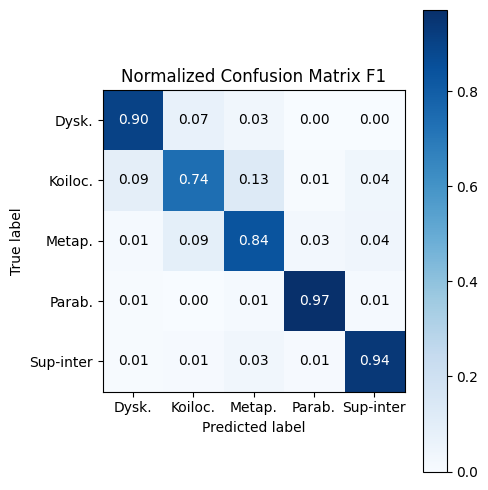

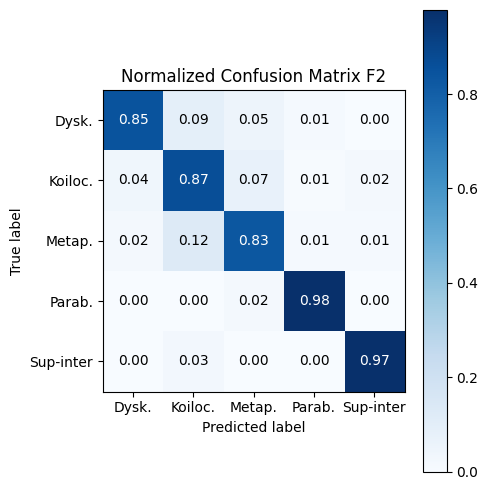

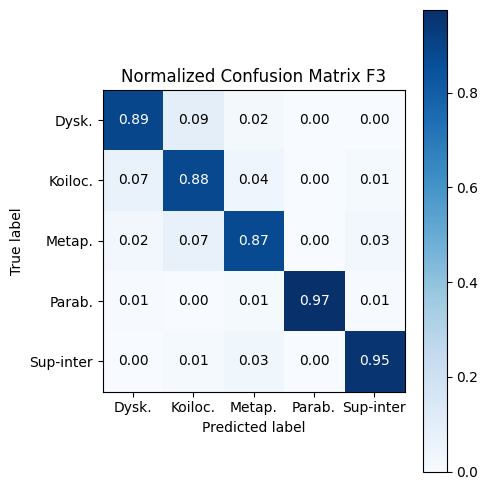

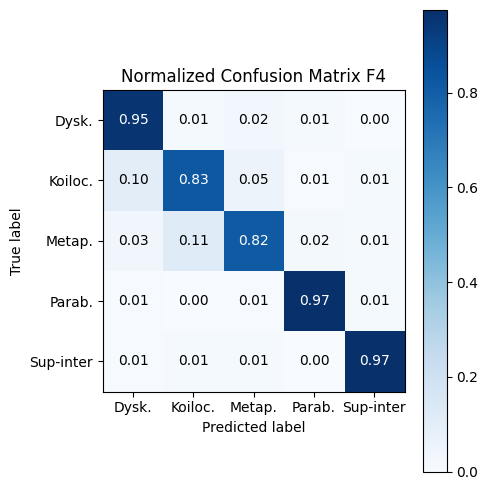

In [ ]:
#vamos a visualizar todas las matrices de confusion para cada fold 
print("MATRIZ DE CONFUSION DE CADA FOLD")
target_names = ['Dysk.','Koiloc.','Metap.','Parab.','Sup-inter']
cm_normalized_total_ORG = np.zeros((5,5))
for fold in range(len(predictions_total)):
    cm = metrics.confusion_matrix(labels_total[fold], predictions_total[fold])
    #print(cm)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #cm_normalized = cm
    cm_normalized_total_ORG = cm_normalized + cm_normalized_total_ORG
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=target_names, yticklabels=target_names,
        title=f'Normalized Confusion Matrix F{fold}',
        ylabel='True label',
        xlabel='Predicted label')

    fmt = '.2f'
    thresh = cm_normalized.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm_normalized[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > thresh else "black")
            
    plt.savefig(f"/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_5Classes/Matrix/matrix_yuv_Nor{fold}.jpg", bbox_inches='tight')
    fig.tight_layout()
    plt.show()


MATRIZ DE CONFUSION PROMEDIO
[[0.89577869 0.06879883 0.03069773 0.00472474 0.        ]
 [0.06830753 0.83460653 0.07428089 0.00370291 0.01910214]
 [0.02160768 0.09515232 0.84780092 0.01161735 0.02382174]
 [0.00492765 0.00124224 0.0117268  0.97598249 0.00612083]
 [0.00365249 0.01471265 0.0175446  0.00227273 0.96181753]]


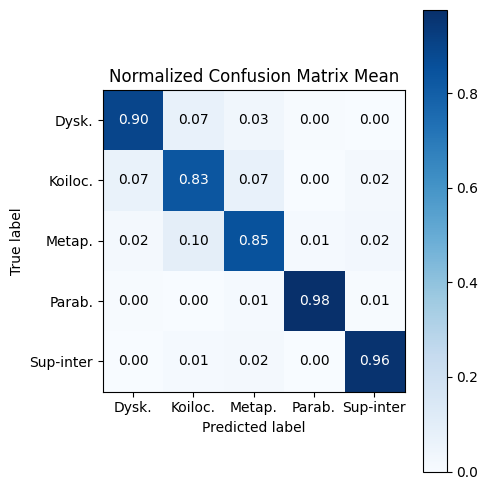

In [ ]:
#matriz de confusion promedio 
print("MATRIZ DE CONFUSION PROMEDIO")
cm_normalized_total = cm_normalized_total_ORG/5
print((cm_normalized_total))
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm_normalized_total, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=target_names, yticklabels=target_names,
    title='Normalized Confusion Matrix Mean',
    ylabel='True label',
    xlabel='Predicted label')

fmt = '.2f'
thresh = cm_normalized_total.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm_normalized_total[i, j], fmt),
                ha="center", va="center",
                color="white" if cm_normalized_total[i, j] > thresh else "black")
        
plt.savefig("/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_5Classes/Matrix/matrix_promedio_yuv_Nor.jpg", bbox_inches='tight')

fig.tight_layout()
plt.show()

In [ ]:
#Obtener las metricas de cada fold
print("METRICAS DE CADA FOLD")
precision_total = np.zeros((1,5))
recalll_total = np.zeros((1,5))
f1_total = np.zeros((1,5))
accuracy_total = 0
for fold in range(len(predictions_total)):
    precision_total = precision_score(labels_total[fold],predictions_total[fold],average=None) + precision_total
    recalll_total = recall_score(labels_total[fold],predictions_total[fold],average=None) + recalll_total
    f1_total = f1_score(labels_total[fold],predictions_total[fold],average=None) + f1_total
    accuracy_total = accuracy_score(labels_total[fold],predictions_total[fold]) + accuracy_total

    report = classification_report(labels_total[fold],predictions_total[fold], target_names=target_names)
    print(report)
    
    with open("/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_5Classes/Reportes_cross_validation/reportes_crossval_yuv.txt", "a") as f:
        f.write(f"===== Fold {fold} =====\n")
        f.write(report)
        f.write("\n\n")  # espacio entre folds

METRICAS DE CADA FOLD
              precision    recall  f1-score   support

       Dysk.       0.92      0.89      0.91       162
     Koiloc.       0.83      0.86      0.85       161
      Metap.       0.88      0.88      0.88       160
      Parab.       1.00      0.98      0.99       161
   Sup-inter       0.96      0.98      0.97       161

    accuracy                           0.92       805
   macro avg       0.92      0.92      0.92       805
weighted avg       0.92      0.92      0.92       805

              precision    recall  f1-score   support

       Dysk.       0.89      0.90      0.90       160
     Koiloc.       0.79      0.74      0.76       140
      Metap.       0.81      0.84      0.82       158
      Parab.       0.96      0.97      0.97       171
   Sup-inter       0.93      0.94      0.93       176

    accuracy                           0.88       805
   macro avg       0.88      0.88      0.88       805
weighted avg       0.88      0.88      0.88       805



In [ ]:
#Metricas promedio
print("METRICAS PROMEDIO")
print("Precision: ",precision_total/5)
print("Recall: ",recalll_total/5)
print("F1-score: ",f1_total/5)
print("Accuracy: ",accuracy_total/5)

with open("/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_5Classes/Reportes_cross_validation/reportes_crossval_yuv.txt", "a") as f:
    f.write(f"===== Average =====\n")
    f.write(f'Precision: {precision_total/5}\n')
    f.write(f'Recall: {recalll_total/5}\n')
    f.write(f'F1-score: {f1_total/5}\n')
    f.write(f'Accuracy: {accuracy_total/5}\n')
    f.write("\n\n")

METRICAS PROMEDIO
Precision:  [[0.90494366 0.82518453 0.8622223  0.97721327 0.95368407]]
Recall:  [[0.89577869 0.83460653 0.84780092 0.97598249 0.96181753]]
F1-score:  [[0.89952872 0.82913698 0.85468541 0.97652432 0.95772448]]
Accuracy:  0.9040558079169371
